<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20fuzzy%20timeseries%20forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forecasting the values for Years 1990, 1991, and 1992
Real Values: 1990=19328, 1991=19337, 1992=18876
Training data spans from 1971 to 1989

Step 1: Universe of Discourse U = [13000, 19633]

Step 2: Partitioned U into 7 intervals of length 947.57

Step 3: Defined 7 Fuzzy Sets (Triangular Membership Functions)

Step 4: Fuzzified Training Data (first 5 and last 5 points)
  Year 1971: 13055 -> A1
  Year 1972: 13563 -> A1
  Year 1973: 13867 -> A1
  Year 1974: 14696 -> A2
  Year 1975: 15460 -> A3
  Year 1985: 15163 -> A3
  Year 1986: 15984 -> A4
  Year 1987: 16859 -> A5
  Year 1988: 18150 -> A6
  Year 1989: 18970 -> A7

Step 5: Fuzzy Logical Relationship Groups
  A1 -> A1, A1, A2
  A2 -> A3
  A3 -> A3, A3, A4, A3, A3, A3, A4
  A4 -> A5, A3, A5
  A5 -> A5, A4, A6
  A6 -> A7

Step 7: Fuzzy Time Series-Markov Chain Model
Transition Counts Matrix:
[[2 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 5 2 0 0 0]
 [0 0 1 0 2 0 0]
 [0 0 0 1 1 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]

Transition Probability Matri

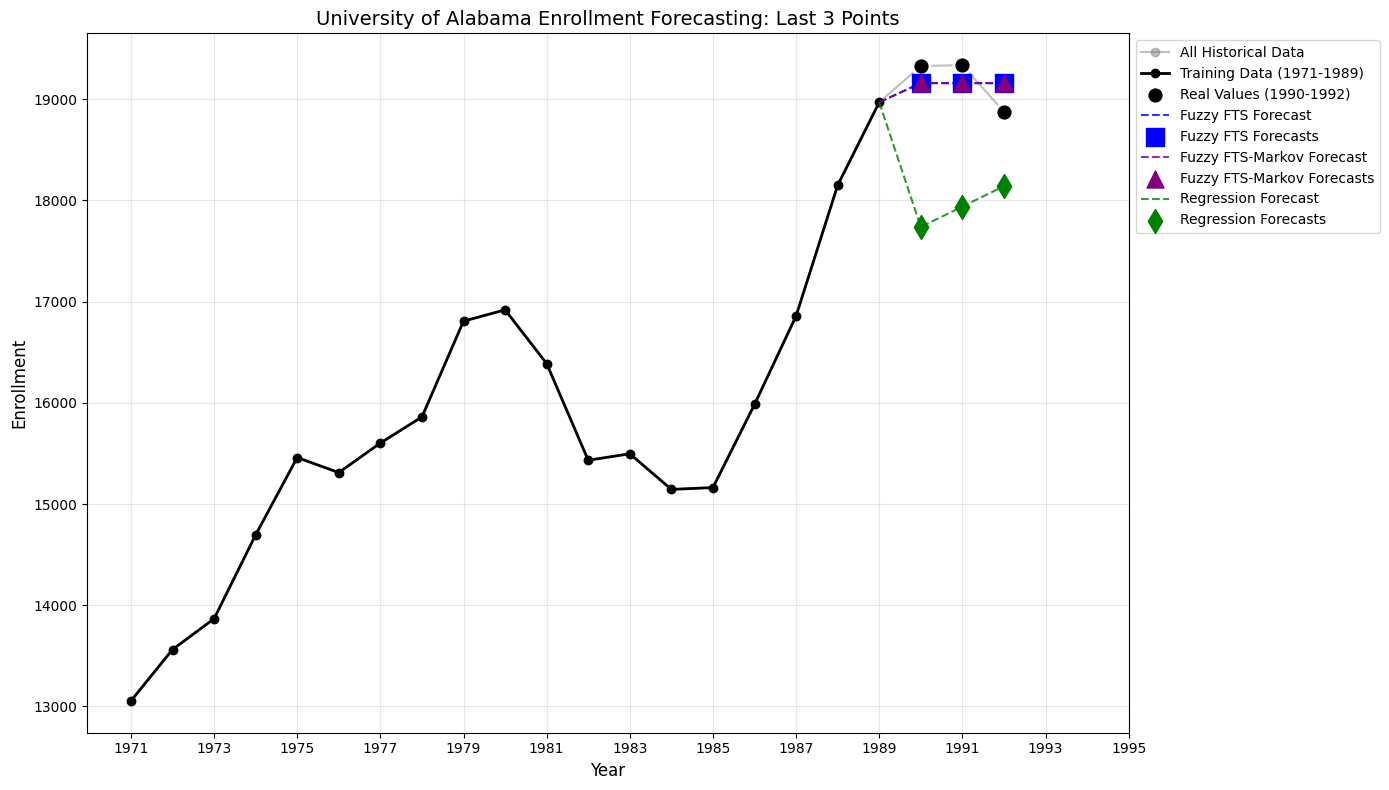


--- Summary of Forecasts for Years 1990-1992 ---
Year   Real     Fuzzy FTS    Markov       Regression  
-------------------------------------------------------
1990   19328    19159.21     19159.21     17737.79    
1991   19337    19159.21     19159.21     17939.30    
1992   18876    19159.21     19159.21     18140.81    

Best performing method for 1990-1992 (lowest MAPE): Fuzzy Time Series


In [1]:

# ---
# title: "Fuzzy Time Series-Markov Chain Forecasting - Predicting Last 3 Elements"
# author: "Assistant (Based on Tsaur, 2012)"
# date: "2024-05-21"
# output: html_document
# ---

# This notebook demonstrates the fuzzy time series-Markov chain model
# based on the methodology described in the paper:
# Tsaur, R.-C. (2012). A fuzzy time series-Markov chain model with an application
# to forecast the exchange rate between the Taiwan and US dollar.
# International Journal of Innovative Computing, Information and Control, 8(7(B)), 4931–4942.

# The focus is on implementing the fuzzy time series-Markov chain model (Sections 2 and 3)
# and using it to predict the last three elements of a time series.

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# --- Example: University of Alabama Enrollment Data (1971-1992) ---
# Using the data from Table 1 of the paper for demonstration.

# Full historical time series data (Years 1971-1992)
full_historical_data = np.array([
    13055, 13563, 13867, 14696, 15460, 15311, 15603, 15861, # 1971-1978
    16807, 16919, 16388, 15433, 15497, 15145, 15163, 15984, # 1979-1986
    16859, 18150, 18970, 19328, 19337, 18876              # 1987-1992
])

# --- Setup for Forecasting the Last 3 Points ---
# We will use data from 1971 to 1989 to forecast the 1990, 1991, and 1992 values.
# The "real" values are:
# 1990: 19328
# 1991: 19337
# 1992: 18876
training_data = full_historical_data[:-3] # Data from 1971 to 1989
real_values = full_historical_data[-3:]   # Actual values for 1990, 1991, 1992
training_years = np.arange(1971, 1971 + len(training_data))
forecast_years = np.arange(1990, 1993) # 1990, 1991, 1992

print("Forecasting the values for Years 1990, 1991, and 1992")
print(f"Real Values: 1990={real_values[0]}, 1991={real_values[1]}, 1992={real_values[2]}")
print(f"Training data spans from {training_years[0]} to {training_years[-1]}")

# --- Step 1: Define the Universe of Discourse (U) ---
# Define U based on the training data (1971-1989), following the paper's approach.
D_min = np.min(training_data)
D_max = np.max(training_data)
D1 = 55   # As per the paper's example for this dataset
D2 = 663  # As per the paper's example for this dataset
U_min = D_min - D1
U_max = D_max + D2
print(f"\nStep 1: Universe of Discourse U = [{U_min}, {U_max}]")

# --- Step 2: Partition the Universe of Discourse (U) into Equal Intervals ---
n_intervals = 7 # As per the paper's example
interval_length = (U_max - U_min) / n_intervals
intervals = []
for i in range(n_intervals):
    start = U_min + i * interval_length
    end = U_min + (i + 1) * interval_length
    intervals.append((start, end))
print(f"\nStep 2: Partitioned U into {n_intervals} intervals of length {interval_length:.2f}")

# --- Step 3: Define Fuzzy Sets on the Universe of Discourse (U) ---
def define_triangular_membership_functions(intervals):
    """Defines triangular membership functions for fuzzy sets."""
    fuzzy_sets = {}
    n = len(intervals)
    for i in range(n):
        center = (intervals[i][0] + intervals[i][1]) / 2
        if i == 0:
            left_base = intervals[i][0]
        else:
            left_base = (intervals[i-1][0] + intervals[i-1][1]) / 2
        if i == n - 1:
            right_base = intervals[i][1]
        else:
            right_base = (intervals[i+1][0] + intervals[i+1][1]) / 2
        fuzzy_sets[f"A{i+1}"] = {
            'center': center,
            'left_base': left_base,
            'right_base': right_base
        }
    return fuzzy_sets

def membership_degree(value, fuzzy_set_params):
    """Calculates the membership degree of a value in a fuzzy set."""
    center = fuzzy_set_params['center']
    left_base = fuzzy_set_params['left_base']
    right_base = fuzzy_set_params['right_base']
    if value <= left_base or value >= right_base:
        return 0.0
    elif left_base < value <= center:
        return (value - left_base) / (center - left_base)
    elif center < value < right_base:
        return (right_base - value) / (right_base - center)
    elif value == center:
        return 1.0
    else:
        return 0.0

fuzzy_sets = define_triangular_membership_functions(intervals)
print(f"\nStep 3: Defined {n_intervals} Fuzzy Sets (Triangular Membership Functions)")

# --- Step 4: Fuzzify the Training Data ---
def fuzzify_data_point(data_point, fuzzy_sets, intervals):
    """Assigns a crisp data point to a fuzzy set."""
    max_membership = -1
    best_set = None
    for set_name, params in fuzzy_sets.items():
        degree = membership_degree(data_point, params)
        if degree > max_membership:
            max_membership = degree
            best_set = set_name
    if max_membership == 0: # Fallback if no membership > 0
         for i, (start, end) in enumerate(intervals):
             if start <= data_point < end or (i == len(intervals) - 1 and data_point == end):
                 best_set = f"A{i+1}"
                 break
    return best_set

fuzzified_training_data = [fuzzify_data_point(data_point, fuzzy_sets, intervals) for data_point in training_data]
print(f"\nStep 4: Fuzzified Training Data (first 5 and last 5 points)")
for i in [0, 1, 2, 3, 4, -5, -4, -3, -2, -1]:
    year = training_years[i]
    data_point = training_data[i]
    fuzzy_set = fuzzified_training_data[i]
    print(f"  Year {year}: {data_point} -> {fuzzy_set}")

# --- Step 5: Determine Fuzzy Logical Relationship Groups ---
def determine_relationships(fuzzified_data):
    """Determines fuzzy logical relationships."""
    relationships = {}
    for i in range(1, len(fuzzified_data)):
        previous_state = fuzzified_data[i-1]
        current_state = fuzzified_data[i]
        if previous_state in relationships:
            relationships[previous_state].append(current_state)
        else:
            relationships[previous_state] = [current_state]
    return relationships

flr_groups = determine_relationships(fuzzified_training_data)
print(f"\nStep 5: Fuzzy Logical Relationship Groups")
for from_state, to_states in flr_groups.items():
    print(f"  {from_state} -> {', '.join(to_states)}")

# --- Step 6: Calculate the Forecasted Output using Fuzzy Time Series ---
def calculate_midpoints(intervals):
    """Calculates the midpoint of each interval."""
    return [(start + end) / 2 for start, end in intervals]

def forecast_next_value_simple(current_fuzzy_state, flr_groups, midpoints, fuzzy_set_names):
    """Forecasts the next value based on fuzzy logical relationships (Simple FTS)."""
    try:
        current_index = fuzzy_set_names.index(current_fuzzy_state)
    except ValueError:
        print(f"Warning: Current state {current_fuzzy_state} not found.")
        return None

    if current_fuzzy_state in flr_groups:
        next_states = flr_groups[current_fuzzy_state]
        if len(next_states) == 1:
            # Rule 2: One-to-one
            next_state = next_states[0]
            try:
                next_index = fuzzy_set_names.index(next_state)
                forecast = midpoints[next_index]
            except ValueError:
                forecast = None
        else:
            # Rule 3: One-to-many
            sum_midpoints = 0
            count = 0
            for state in next_states:
                try:
                    index = fuzzy_set_names.index(state)
                    sum_midpoints += midpoints[index]
                    count += 1
                except ValueError:
                    pass
            if count > 0:
                forecast = sum_midpoints / count
            else:
                forecast = None
    else:
        # Rule 1: No relationship (empty group)
        forecast = midpoints[current_index]

    return forecast

# --- Step 7: Fuzzy Time Series-Markov Chain Model ---
# Calculate transition probabilities for the Markov chain component
def calculate_transition_matrix(flr_groups, fuzzy_set_names):
    """Calculates the Markov transition matrix from FLR groups."""
    n = len(fuzzy_set_names)
    # Initialize transition count matrix
    transition_counts = np.zeros((n, n))

    # Count transitions
    for from_state, to_states in flr_groups.items():
        try:
            from_idx = fuzzy_set_names.index(from_state)
            for to_state in to_states:
                try:
                    to_idx = fuzzy_set_names.index(to_state)
                    transition_counts[from_idx, to_idx] += 1
                except ValueError:
                    pass # Ignore unknown states
        except ValueError:
            pass # Ignore unknown states

    # Convert counts to probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        row_sum = np.sum(transition_counts[i, :])
        if row_sum > 0:
            transition_matrix[i, :] = transition_counts[i, :] / row_sum
        # If no transitions from state i, keep row as zeros (or could set to self-transition)
        # Following the paper, if no transitions, we might use the simple FTS rule
        # For now, we'll handle this in the forecasting step

    return transition_matrix, transition_counts

# Calculate transition matrix
fuzzy_set_names = [f"A{i+1}" for i in range(n_intervals)]
transition_matrix, transition_counts = calculate_transition_matrix(flr_groups, fuzzy_set_names)
midpoints = calculate_midpoints(intervals)

print(f"\nStep 7: Fuzzy Time Series-Markov Chain Model")
print("Transition Counts Matrix:")
print(transition_counts.astype(int))
print("\nTransition Probability Matrix:")
print(transition_matrix)

# Forecast using Fuzzy Time Series-Markov Chain
def forecast_next_value_markov(current_fuzzy_state, flr_groups, transition_matrix, midpoints, fuzzy_set_names):
    """Forecasts the next value using the Markov chain approach."""
    try:
        current_index = fuzzy_set_names.index(current_fuzzy_state)
    except ValueError:
        print(f"Warning: Current state {current_fuzzy_state} not found.")
        return None

    # Get the transition probabilities from the current state
    probabilities = transition_matrix[current_index, :]

    # Check if there are any transitions
    if np.sum(probabilities) == 0:
        # No transitions recorded, fall back to simple FTS rule
        # This corresponds to Rule 1 in the Markov extension where Pij=0 for all j
        return midpoints[current_index]

    # Calculate weighted average of midpoints
    # This implements Rule 2 of the Markov extension
    forecast = np.dot(probabilities, midpoints)
    return forecast

# --- Perform Forecasting for the Last 3 Points ---
print(f"\n--- Forecasting the Last 3 Points ---")

# Store forecasts
forecasts_fuzzy = []
forecasts_markov = []
forecasts_regression = []

# Get the last fuzzified value from training data to start forecasting
last_fuzzy_state = fuzzified_training_data[-1] # A7

# --- Forecast for 1990 ---
print(f"\nForecasting for Year {forecast_years[0]} (1990):")
print(f"  Current State: {last_fuzzy_state}")

# Fuzzy Time Series Forecast
forecast_1990_fuzzy = forecast_next_value_simple(last_fuzzy_state, flr_groups, midpoints, fuzzy_set_names)
forecasts_fuzzy.append(forecast_1990_fuzzy)
print(f"  Fuzzy FTS Forecast: {forecast_1990_fuzzy:.2f}")

# Markov Chain Forecast
forecast_1990_markov = forecast_next_value_markov(last_fuzzy_state, flr_groups, transition_matrix, midpoints, fuzzy_set_names)
forecasts_markov.append(forecast_1990_markov)
print(f"  Fuzzy FTS-Markov Forecast: {forecast_1990_markov:.2f}")

# For subsequent forecasts, we need to update the state
# In a full implementation, we might re-fuzzify the forecast, but for simplicity,
# we'll use the state that corresponds to the forecast value
def get_state_for_value(value, fuzzy_sets, intervals):
    """Get the fuzzy state for a given value."""
    return fuzzify_data_point(value, fuzzy_sets, intervals)

# Update state for next forecast
if forecast_1990_markov is not None:
    current_state_1990 = get_state_for_value(forecast_1990_markov, fuzzy_sets, intervals)
else:
    current_state_1990 = last_fuzzy_state

# --- Forecast for 1991 ---
print(f"\nForecasting for Year {forecast_years[1]} (1991):")
print(f"  Current State: {current_state_1990}")

# Fuzzy Time Series Forecast
forecast_1991_fuzzy = forecast_next_value_simple(current_state_1990, flr_groups, midpoints, fuzzy_set_names)
forecasts_fuzzy.append(forecast_1991_fuzzy)
print(f"  Fuzzy FTS Forecast: {forecast_1991_fuzzy:.2f}")

# Markov Chain Forecast
forecast_1991_markov = forecast_next_value_markov(current_state_1990, flr_groups, transition_matrix, midpoints, fuzzy_set_names)
forecasts_markov.append(forecast_1991_markov)
print(f"  Fuzzy FTS-Markov Forecast: {forecast_1991_markov:.2f}")

# Update state for next forecast
if forecast_1991_markov is not None:
    current_state_1991 = get_state_for_value(forecast_1991_markov, fuzzy_sets, intervals)
else:
    current_state_1991 = current_state_1990

# --- Forecast for 1992 ---
print(f"\nForecasting for Year {forecast_years[2]} (1992):")
print(f"  Current State: {current_state_1991}")

# Fuzzy Time Series Forecast
forecast_1992_fuzzy = forecast_next_value_simple(current_state_1991, flr_groups, midpoints, fuzzy_set_names)
forecasts_fuzzy.append(forecast_1992_fuzzy)
print(f"  Fuzzy FTS Forecast: {forecast_1992_fuzzy:.2f}")

# Markov Chain Forecast
forecast_1992_markov = forecast_next_value_markov(current_state_1991, flr_groups, transition_matrix, midpoints, fuzzy_set_names)
forecasts_markov.append(forecast_1992_markov)
print(f"  Fuzzy FTS-Markov Forecast: {forecast_1992_markov:.2f}")

# --- Method 2: Linear Regression Forecasting ---
print(f"\n--- Method 2: Linear Regression Forecasting (for comparison) ---")
X_train = np.arange(len(training_data)).reshape(-1, 1)
y_train = training_data
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast the last 3 points
X_forecast = np.array([[len(training_data)], [len(training_data)+1], [len(training_data)+2]])
forecasts_regression = model.predict(X_forecast)

for i, (year, forecast) in enumerate(zip(forecast_years, forecasts_regression)):
    print(f"  Regression Forecast for {year}: {forecast:.2f}")

# --- Calculate MAPE for Each Method ---
def calculate_mape(real, forecast):
    """Calculate MAPE for forecast points."""
    return np.mean(np.abs((real - forecast) / real)) * 100

# Convert lists to numpy arrays for calculation
forecasts_fuzzy = np.array(forecasts_fuzzy)
forecasts_markov = np.array(forecasts_markov)

# Handle potential None values
forecasts_fuzzy = np.where(forecasts_fuzzy == None, np.nan, forecasts_fuzzy)
forecasts_markov = np.where(forecasts_markov == None, np.nan, forecasts_markov)

mape_fuzzy = calculate_mape(real_values, forecasts_fuzzy)
mape_markov = calculate_mape(real_values, forecasts_markov)
mape_regression = calculate_mape(real_values, forecasts_regression)

print(f"\n--- Forecast Accuracy (MAPE) for Years 1990-1992 ---")
print(f"Fuzzy Time Series MAPE: {mape_fuzzy:.2f}%")
print(f"Fuzzy Time Series-Markov MAPE: {mape_markov:.2f}%")
print(f"Linear Regression MAPE: {mape_regression:.2f}%")

# --- Visualization: Final Comparison Plot ---
plt.figure(figsize=(14, 8))

# Plot all historical data
all_years = np.arange(1971, 1971 + len(full_historical_data))
plt.plot(all_years, full_historical_data, marker='o', linestyle='-', color='grey', alpha=0.5, label='All Historical Data')

# Highlight training data
plt.plot(training_years, training_data, marker='o', linestyle='-', color='black', label='Training Data (1971-1989)', linewidth=2)

# Mark the real values for 1990, 1991, 1992
plt.scatter(forecast_years, real_values, color='black', marker='o', s=150,
            label=f'Real Values ({forecast_years[0]}-{forecast_years[2]})', zorder=5, edgecolors='white', linewidths=2)

# Plot forecasted values
# Fuzzy FTS Forecasts
plt.plot([training_years[-1]] + list(forecast_years),
         [training_data[-1]] + list(forecasts_fuzzy),
         linestyle='--', color='blue', alpha=0.8, label='Fuzzy FTS Forecast')
plt.scatter(forecast_years, forecasts_fuzzy, color='blue', marker='s', s=150,
            label=f'Fuzzy FTS Forecasts', zorder=5)

# Markov Forecasts
plt.plot([training_years[-1]] + list(forecast_years),
         [training_data[-1]] + list(forecasts_markov),
         linestyle='--', color='purple', alpha=0.8, label='Fuzzy FTS-Markov Forecast')
plt.scatter(forecast_years, forecasts_markov, color='purple', marker='^', s=150,
            label=f'Fuzzy FTS-Markov Forecasts', zorder=5)

# Regression Forecasts
plt.plot([training_years[-1]] + list(forecast_years),
         [training_data[-1]] + list(forecasts_regression),
         linestyle='--', color='green', alpha=0.8, label='Regression Forecast')
plt.scatter(forecast_years, forecasts_regression, color='green', marker='d', s=150,
            label=f'Regression Forecasts', zorder=5)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Enrollment', fontsize=12)
plt.title('University of Alabama Enrollment Forecasting: Last 3 Points', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1971, 1996, 2)) # Show years
plt.tight_layout()
plt.show()

# --- Summary Table ---
print(f"\n--- Summary of Forecasts for Years 1990-1992 ---")
print(f"{'Year':<6} {'Real':<8} {'Fuzzy FTS':<12} {'Markov':<12} {'Regression':<12}")
print("-" * 55)
for i in range(3):
    print(f"{forecast_years[i]:<6} {real_values[i]:<8} {forecasts_fuzzy[i]:<12.2f} {forecasts_markov[i]:<12.2f} {forecasts_regression[i]:<12.2f}")

# Determine the best method based on MAPE
mape_dict = {
    'Fuzzy Time Series': mape_fuzzy,
    'Fuzzy FTS-Markov': mape_markov,
    'Linear Regression': mape_regression
}
best_method = min(mape_dict, key=mape_dict.get)
print(f"\nBest performing method for 1990-1992 (lowest MAPE): {best_method}")